In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [31]:
df_users = pd.read_csv('users.csv')
df_transactions = pd.read_csv('transactions.csv')
df_countries = pd.read_csv('countries.csv')
df_currency_details = pd.read_csv('currency_details.csv')

In [30]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 688651 entries, 0 to 688650
Data columns (total 13 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   currency                         688651 non-null  object 
 1   amount                           688651 non-null  int64  
 2   state                            688651 non-null  object 
 3   created_date                     688651 non-null  object 
 4   merchant_category                223065 non-null  object 
 5   merchant_country                 483055 non-null  object 
 6   entry_method                     688651 non-null  object 
 7   user_id                          688651 non-null  object 
 8   type                             688651 non-null  object 
 9   source                           688651 non-null  object 
 10  id                               688651 non-null  object 
 11  amount_usd                       635328 non-null  float64
 12  tr

### Users
- Users dataset has all caps column names
- Useful features
    - has_email, kyc, failed_sign_in_attempts
- Create features:
    - age of account (from created_date)
- Numerical features:
    - `has_email`, `birth_year`, `failed_sign_in_attempts`
### Transactions
- This dataset also has all caps column names
- transaction_state = completed or failed can determine fraudster or not.
- Create features:
    - number of failed transactions
    - number of transactions above median transaction value
- Numerical features:
    - `amount`, `amount_usd`
### Currency Details
- all caps columns
- has a `IS_CRYPTO` column which might be useful?
### Country
- Let's have complete name of the country, so merge this table too.

## Initial EDA
- Let's create some aggregate metrics on the transactions dataset grouped by `USER_ID`. Let's call this `df_transaction_metrics`
- Specifically, `n_failed_transactions`, `n_transactions_over_median_value`
- Then join `df_transactions_metrics` with `df_users` dataset.


In [42]:
for df in [df_users, df_transactions, df_currency_details, df_countries]:
    df.columns = df.columns.str.lower()

df_users.loc[df_users['is_fraudster'] == False]


,id,has_email,phone_country,is_fraudster,terms_version,created_date,state,country,birth_year,kyc,failed_sign_in_attempts
0,1872820f-e3ac-4c02-bdc7-727897b60043,1,GB||JE||IM||GG,False,2018-05-25,2017-08-06 07:33:33.341000,ACTIVE,GB,1971,PASSED,0
1,545ff94d-66f8-4bea-b398-84425fb2301e,1,GB||JE||IM||GG,False,2018-01-01,2017-03-07 10:18:59.427000,ACTIVE,GB,1982,PASSED,0
2,10376f1a-a28a-4885-8daa-c8ca496026bb,1,ES,False,2018-09-20,2018-05-31 04:41:24.672000,ACTIVE,ES,1973,PASSED,0
3,fd308db7-0753-4377-879f-6ecf2af14e4f,1,FR,False,2018-05-25,2018-06-01 17:24:23.852000,ACTIVE,FR,1986,PASSED,0
4,755fe256-a34d-4853-b7ca-d9bb991a86d3,1,GB||JE||IM||GG,False,2018-09-20,2017-08-09 15:03:33.945000,ACTIVE,GB,1989,PASSED,0
...,...,...,...,...,...,...,...,...,...,...,...
9939,544777fa-b18b-4b9e-bcdc-7e10f4e0712c,1,GB||JE||IM||GG,False,NaN,2017-01-27 18:23:38.486000,ACTIVE,GB,1998,PASSED,0
9940,438f235a-3f6e-4663-ba95-fa107b11bfc5,1,LT,False,2018-01-13,2017-12-20 11:00:03.873000,ACTIVE,LT,1994,NONE,0
9941,268d4b0a-dd32-4ca3-ba6f-d571a1fd9428,1,PT,False,2018-05-25,2018-07-11 10:12:00.098000,ACTIVE,PT,1958,PASSED,0
9942,55995ada-5797-4f7e-82da-62a3d4051e8b,1,GB||JE||IM||GG,False,2018-03-20,2018-02-23 16:24:40.716000,ACTIVE,GB,1961,NONE,0


In [34]:
df_transactions['transaction_greater_than_median'] = df_transactions.groupby('user_id')['amount']\
    .transform(lambda x: x > x.median())
df_transactions.head()

,currency,amount,state,created_date,merchant_category,merchant_country,entry_method,user_id,type,source,id,amount_usd,transaction_greater_than_median
0,GBP,4420,COMPLETED,2017-12-10 16:38:55.577,NaN,NLD,chip,3ff52b92-d416-4e22-8cad-018f500d4bbc,ATM,GAIA,367bf5f9-7cce-4683-90b9-d3c011bf4c87,3268.0,True
1,PLN,1500,COMPLETED,2017-12-10 16:37:24.792,point_of_interest,POL,manu,76cbaad3-4721-4a3b-92b9-3eb9e9319565,CARD_PAYMENT,GAIA,ff6802b9-360d-4efe-b09b-f99c6cac3383,NaN,True
2,GBP,191,COMPLETED,2017-12-10 16:37:16.234,airport,PRT,chip,7bcaa34e-b889-4582-9c29-0b3bab34fb8c,CARD_PAYMENT,GAIA,ddb4a930-7d8a-4f38-9079-ddc4b0db980e,141.0,False
3,GBP,10000,COMPLETED,2017-12-10 16:34:42.592,NaN,NaN,misc,b3a6762b-a940-4459-bb1d-8e28e151f901,TOPUP,HERA,080ef0be-850a-4f14-ab03-28ff68e6b797,7394.0,True
4,EUR,1159,COMPLETED,2017-12-10 16:34:17.88,NaN,FRA,manu,f5723f5e-5a00-4851-ae1d-5c11146aa491,CARD_PAYMENT,GAIA,bd13abac-4004-4c67-9bb7-90a42b027e82,977.0,True


Is Fraudster: [False  True]


[Text(0, 0, '9646'), Text(0, 0, '298')]

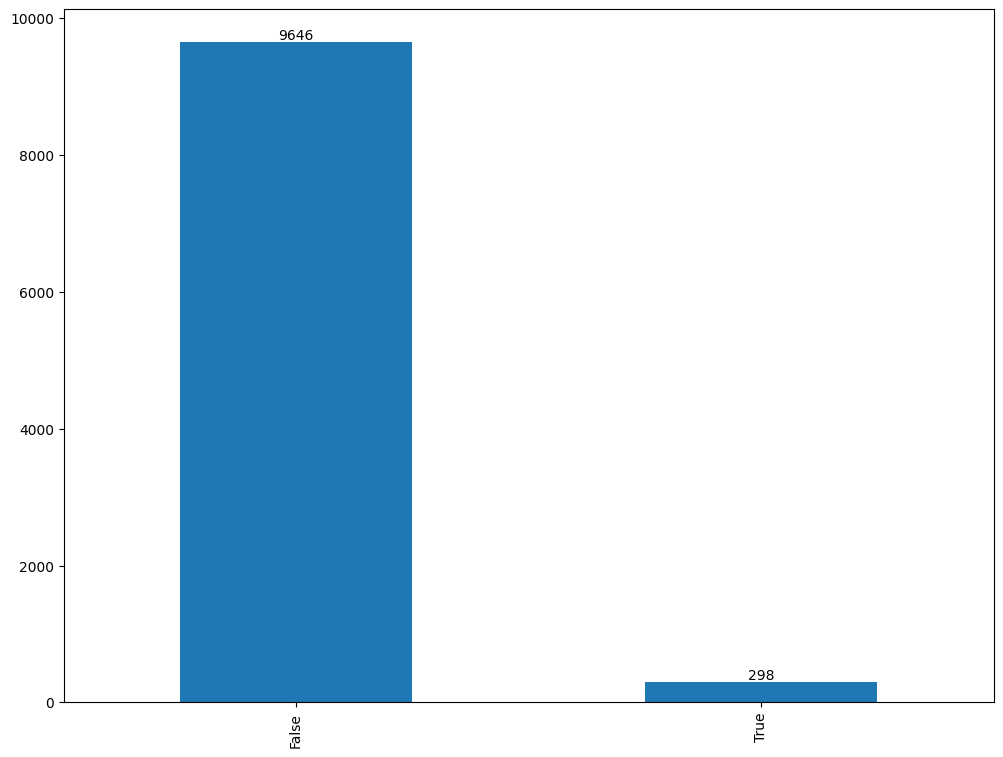

In [36]:
# Visualize the target variable
print(f'Is Fraudster: {df_users.is_fraudster.unique()}')

ax = df_users['is_fraudster'].value_counts().plot(kind='bar', figsize=(12,9))
ax.bar_label(ax.containers[0])

KYC: ['PASSED' 'NONE' 'FAILED' 'PENDING']


[Text(0, 0, '6969'), Text(0, 0, '2631'), Text(0, 0, '270'), Text(0, 0, '74')]

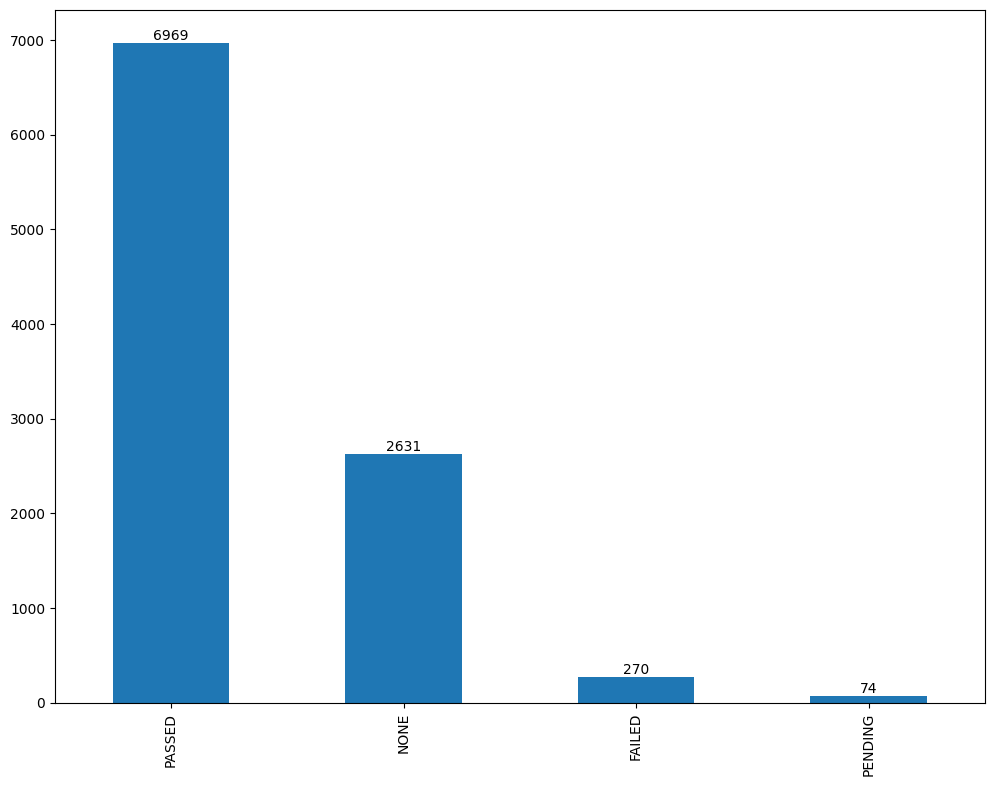

In [38]:
#Visualize the KYC variable
print(f'KYC: {df_users.kyc.unique()}')

ax = df_users['kyc'].value_counts().plot(kind='bar', figsize=(12,9))
ax.bar_label(ax.containers[0])